In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3, glob, os
import pandas as pd, seaborn as sn, numpy as np
sn.set_context('talk')

In [2]:
# Hack to force Python 2 to recognise utf-8 encodings. See here:
# http://jonathansoma.com/tutorials/international-data/python-and-utf-8/
# Note that using this breaks subsequent print statements in the 
# notebook, which is annoying!
#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

# Krypsiv project

Therese has a project on Krypsiv (bulbous rushes) and the first draft of the 2016 annual report is due in mid-November. This notebook explores some options for plotting different data types. **Finalised plots will be required no later than November 12th**.

For reference, the 2015 report is here:

K:\Avdeling\318 Ferskvannsøkologi\Prosjekter\2016 JBovervåk16-18 (TFM)\05 Rapport

and the raw data files are here:

K:\Avdeling\318 Ferskvannsøkologi\Prosjekter\2016 JBovervåk16-18 (TFM)\07 Grunndata

The file `Grunndata JBovervåk1618.xlsx` includes most of the data for all three years (2014 to 2016 inclusive). For further background, see the e-mail from Therese received 24/10/2016 at 20:23.

## 1. Compositional proportions

Page 21 of the 2015 report shows the proportion of the substrate covered by different classes of benthic algae; page 27 shows the proportions of different substrate types. Therese would like a visual presentation of these data for all three years.

As a start, I've extracted the proportions data from the raw spreadsheets into a new Excel file called `proportions.xlsx`. Note that for substrate there are several cases where the proportions sum to more than 100%, because the classes are not mutually exclusive. This is a little counter-intuitive and may pose problems for the data visualisation, so I might need to revisit this with Therese to see if we can aggregate the classes a bit.

Note also that I'm having some problems with special Norwegian characters in the site names causing `Unicode Errors` in my code. These issues should be fixed by uncommenting the cell above, but for testing and development I've decided to create a new `Name` column with the non-ASCII characters removed, as it's becoming difficult to know which errors are caused by my code and which are due to Unicode conversions.

During the initial meeting with Therese and Kate, I suggested representing the different proportions using [radar charts or spider diagrams](https://en.wikipedia.org/wiki/Radar_chart) but, having looked at the data, I think this approach will be messy and probably difficult to interpret. A better option may be to use some kind of **facet grid of bar charts**. I'll try a few different versions below.

### 1.1. Read data

First, read the proportions data.

In [3]:
# Read data
in_xls = (r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data'
          r'\Tidied\proportions.xlsx')
df = pd.read_excel(in_xls, sheetname='proportions')

# Define cols for algae and substrate
alg_cols = set(['BEGlost', 'BEGfast', 'BEGdelvis', 'BEGfri', 'BEGsum'])
sub_cols = set(['Boulders', 'Cobbles', 'Gravel', 'Fine gravel', 'Sand', 'Clay_silt', 'Organic', 'SUBsum'])

df.head()

,Kortnavn,Name,ID,River,Year,BEGlost,BEGfast,BEGdelvis,BEGfri,BEGsum,Boulders,Cobbles,Gravel,Fine gravel,Sand,Clay_silt,Organic,SUBsum
0,LOG,LOG,1,Mandalselva,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LOG,LOG,1,Mandalselva,2015,5.0,0.0,0.0,95.0,100.0,40.0,40.0,10.0,5.0,5.0,0.0,0.0,100.0
2,LOG,LOG,1,Mandalselva,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ÅSE,ASE,2,Mandalselva,2014,0.0,0.0,100.0,0.0,100.0,20.0,20.0,40.0,15.0,5.0,0.0,0.0,100.0
4,ÅSE,ASE,2,Mandalselva,2015,90.0,0.0,0.0,10.0,100.0,10.0,30.0,30.0,25.0,5.0,0.0,0.0,100.0


### 1.2. Extract algal coverage dataset

In this notebook I'm just going to focus on the algal adat. The substrate data can be processed pretty quickly in exactly the same way, once I've discussed the numbers with Therese and we've decided how we want to format the plots.

In [4]:
# Get just the algal data
alg_df = df[list(set(df.columns) - sub_cols)]
del alg_df['BEGsum']

# 'Melt' to long data format
alg_df = pd.melt(alg_df, 
                 id_vars=['Kortnavn', 'Name', 'ID', 'River', 'Year'], 
                 var_name='Class', 
                 value_name='Proportion (%)')

alg_df.head()

,Kortnavn,Name,ID,River,Year,Class,Proportion (%)
0,LOG,LOG,1,Mandalselva,2014,BEGfast,NaN
1,LOG,LOG,1,Mandalselva,2015,BEGfast,0.0
2,LOG,LOG,1,Mandalselva,2016,BEGfast,NaN
3,ÅSE,ASE,2,Mandalselva,2014,BEGfast,0.0
4,ÅSE,ASE,2,Mandalselva,2015,BEGfast,0.0


#### 1.2.1. Separate bar charts

The simplest and perhaps clearest way to visualise these data is to plot a separate bar chart for each site in each year, arranged with years as columns and sites as rows. This generates a 3 by 6 grid for each of the three rivers (i.e. 54 bar charts in total). This works OK, but the output takes up a lot of space - probably one page per river. Perhaps this is too much?

The example below shows the results for Mandalselva.

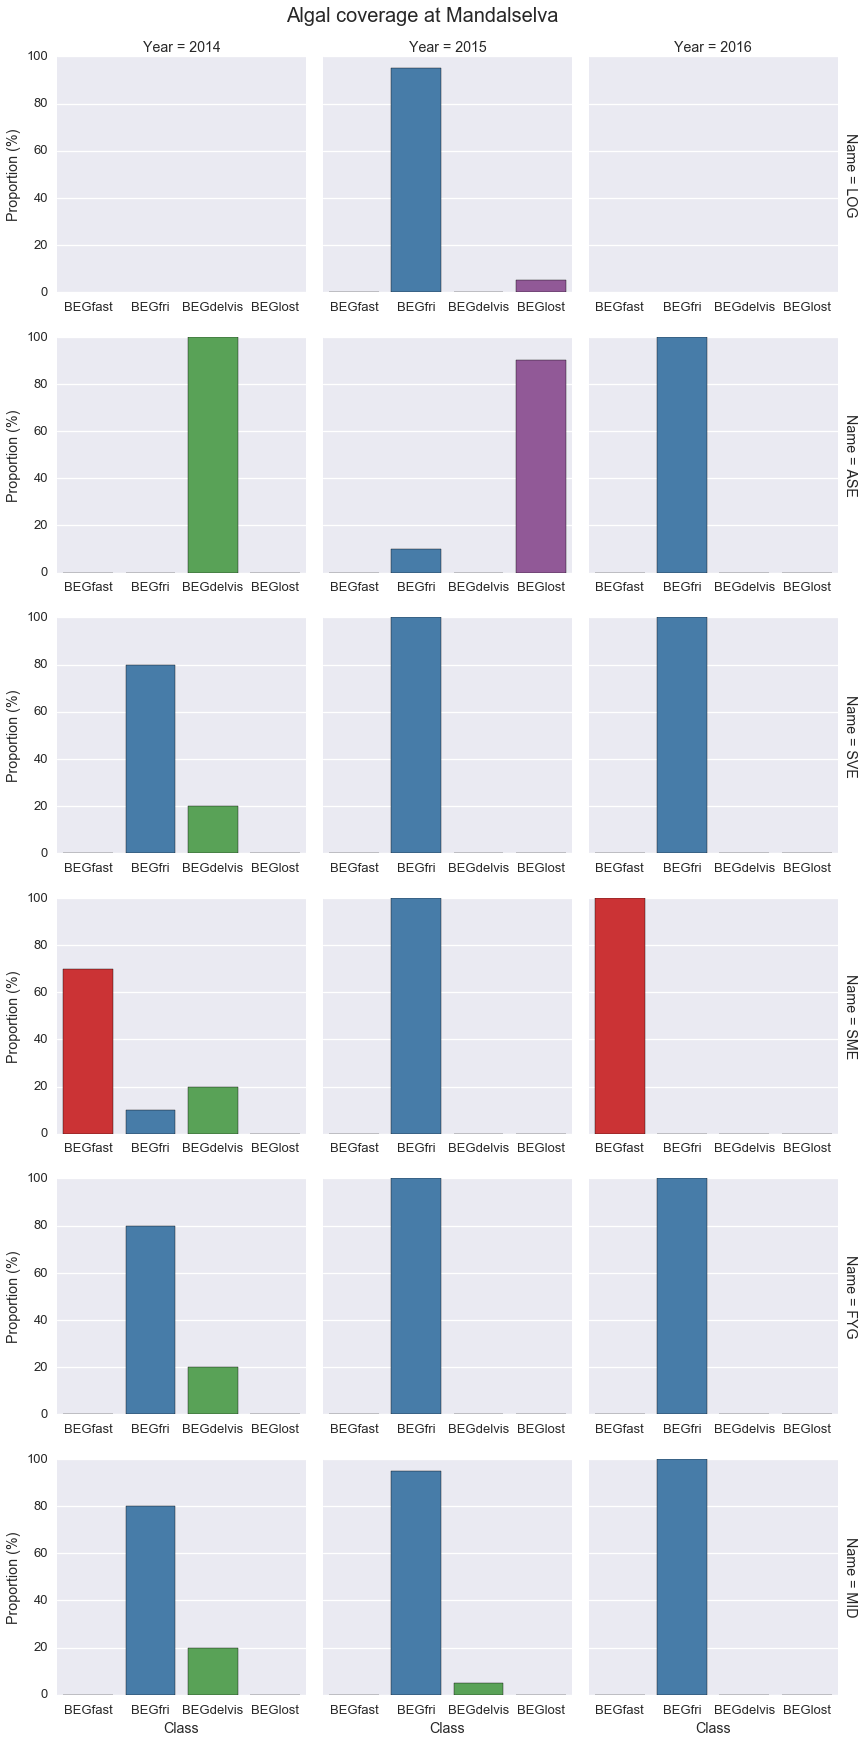

In [5]:
# Get data for Mandalselva
df2 = alg_df.query('River == "Mandalselva"')

# Plot
sn.factorplot(x='Class', y='Proportion (%)', 
              row='Name', col='Year',
              data=df2, 
              kind='bar',
              sharex=False, 
              margin_titles=True,
              palette='Set1')

plt.suptitle('Algal coverage at Mandalselva', fontsize=20, y=1.01)

#### 1.2.2. Aggregate years

One way to compress the plot above is to use bars only for the value of the **median** year. Proportions for the other two years can then be represented by whiskers to show the range of variability within each class. This reduces the three columns on the plot above to a single column 6 plots high, which I've rearranged into a grid of 3 by 2 to save space.

This method of presenting the data is more compact, but we lose the time-ordering compared to the version above i.e. it is possible to read off the values for each year, but we don't know which is year is which.

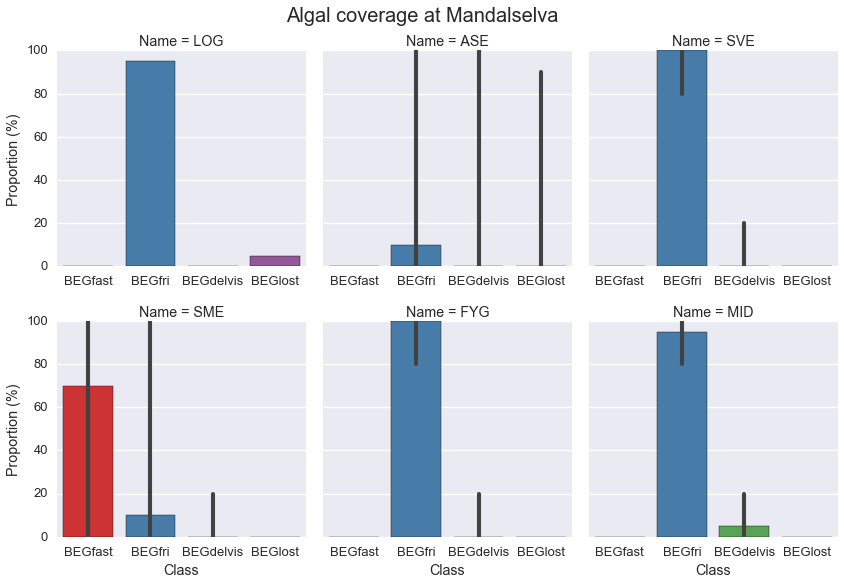

In [6]:
# Aggregate years for Mandalselva
sn.factorplot(x='Class', y='Proportion (%)', 
              col='Name', col_wrap=3,
              data=df2, 
              kind='bar',
              sharex=False, 
              estimator=np.median,
              palette='Set1')

plt.suptitle('Algal coverage at Mandalselva', fontsize=20, y=1.02)

Using this method, it is possible to represent the whole dataset on a 3 by 6 grid, where each column represents a river, and each row a site on that river. In this way, all the data can be represented on a single page (but we still lose the time ordering).

**Note:** We actually need a 3 by 7 grid, as there are 7 sites on the Otra.

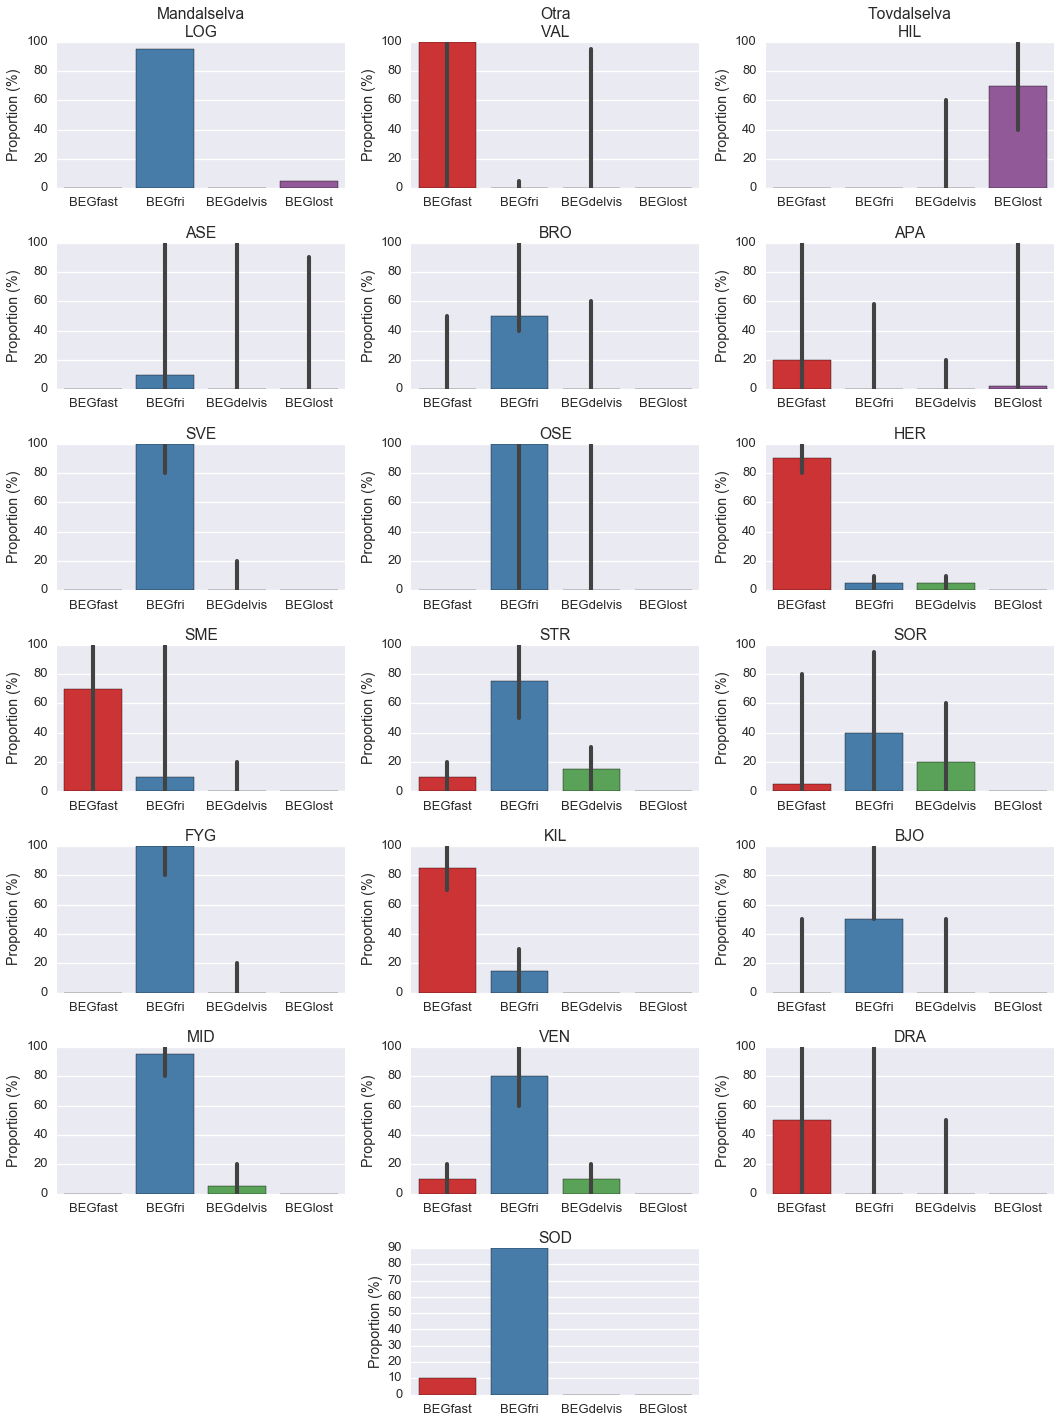

In [7]:
# Aggregated years for all sites
fig, axes = plt.subplots(nrows=7, ncols=3, 
                         figsize=(15,20))

# Rivers by column
for col, riv in enumerate(['Mandalselva', 'Otra', 'Tovdalselva']):
    riv_df = alg_df.query('River == @riv')

    # Sites by row
    for row, site in enumerate(riv_df['Name'].unique()):
        site_df = riv_df.query('Name == @site')
        sn.barplot(x='Class', y='Proportion (%)', 
                   data=site_df, 
                   ax=axes[row, col],
                   estimator=np.median,
                   palette='Set1') 
        
        # Add labels
        axes[row, col].set_ylabel('Proportion (%)')
        axes[row, col].set_xlabel('')
        if row == 0:
            axes[row, col].set_title('%s\n%s' % (riv, site))
        else:
            axes[row, col].set_title(site)

# We only have 6 sites at Mandalselva and Tovdalselva, so
# remove 7th row for these
fig.delaxes(axes[6, 0])
fig.delaxes(axes[6, 2])

plt.tight_layout()

#### 1.2.3. Aggregate categories

A different way to aggregate these data is to group the classes into stacked bar charts, which means we can separate out the years again. As above, this allows the whole dataset to be represented on a 3 by 6 (7 for Otra) grid, and with this method the time ordering is preserved too, but it's more difficult to read off the actual proportions for each class. It does give a reasonable visual impression of the relative class proportions, though, which is perhpas all that's required?

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


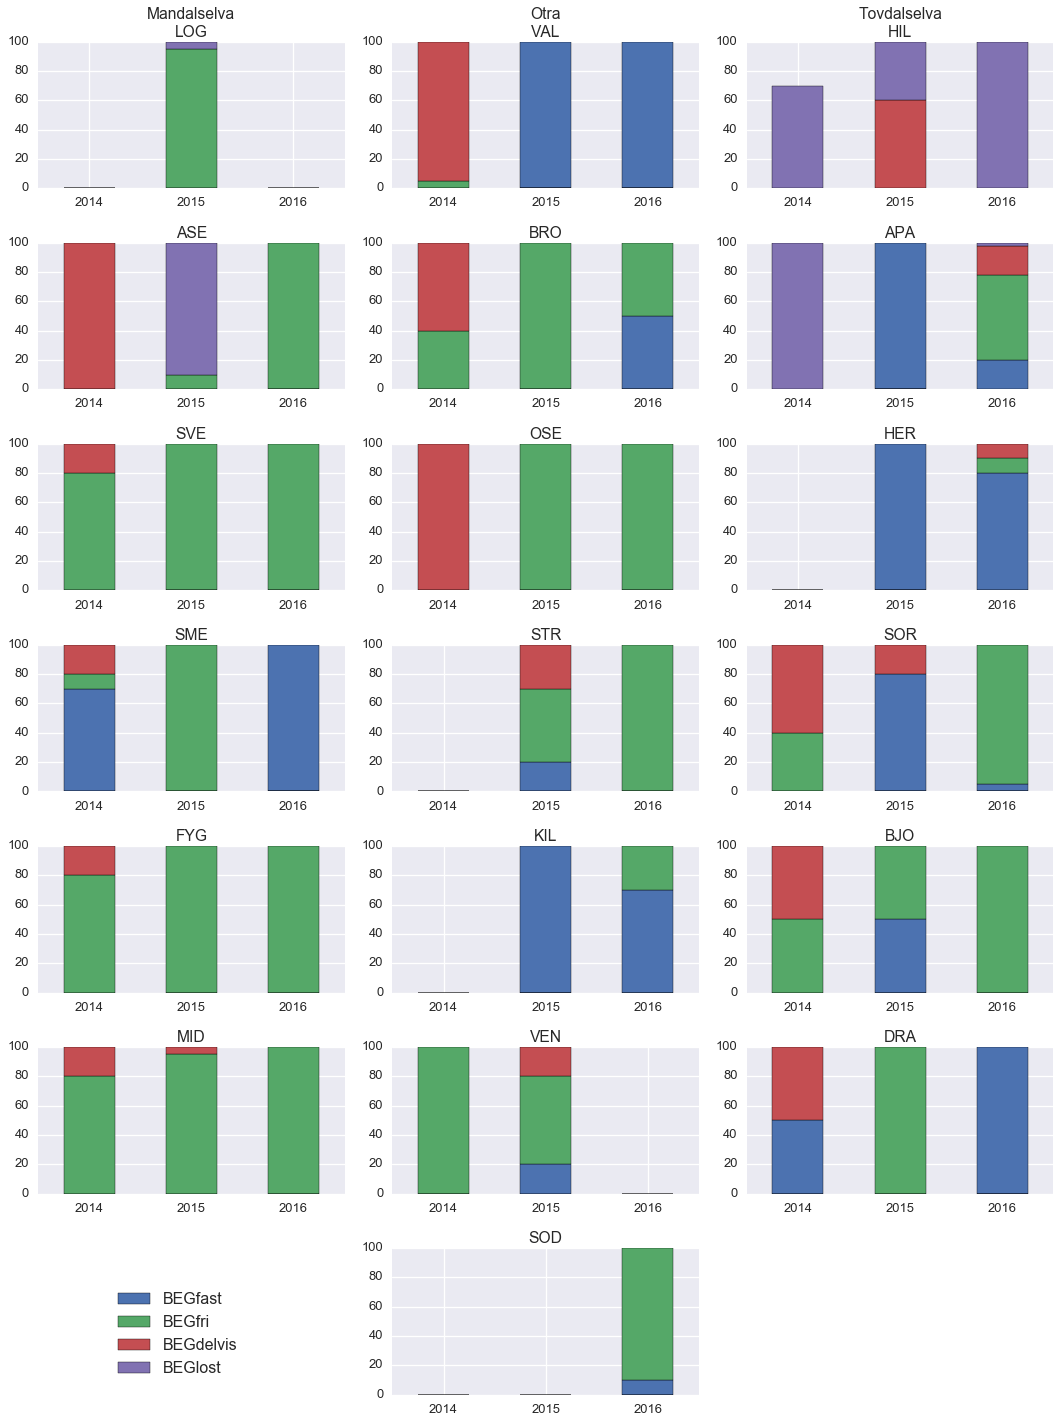

In [8]:
# Aggregate classes

# Get just the algal data again
alg_df2 = df[list(set(df.columns) - sub_cols)]
del alg_df2['BEGsum']

# Empty df with ordered index. Used to fill missing
# years at some sites with NaN
idx_df = pd.DataFrame({}, index=[2014, 2015, 2016])

# Plot
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15,20))

# Rivers by column
for col, riv in enumerate(['Mandalselva', 'Otra', 'Tovdalselva']):
    riv_df = alg_df2.query('River == @riv')

    # Sites by row
    for row, site in enumerate(riv_df['Name'].unique()):
        site_df = riv_df.query('Name == @site')
        site_df.drop(['River', 'Kortnavn', 'ID', 'Name'], axis=1, inplace=True)
        site_df.set_index('Year', inplace=True)
        site_df = idx_df.join(site_df)
        site_df.plot.bar(stacked=True, ax=axes[row, col], legend=False)

        # Titles etc.
        if row == 0:
            axes[row, col].set_title('%s\n%s' % (riv, site))
        else:
            axes[row, col].set_title(site)
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticklabels(axes[row, col].xaxis.get_majorticklabels(), 
                                       rotation=0)
        
        # Legend
        if (row==6) and (col==1):
            axes[row, col].legend(loc='upper center', bbox_to_anchor=(-0.7, 0.8), 
                                  fontsize=16)

# We only have 6 sites at Mandalselva and Tovdalselva, so
# remove 7th row for these
fig.delaxes(axes[6, 0])
fig.delaxes(axes[6, 2])

plt.tight_layout()

### 1.3. Nuisance versus Non-nuisance sites

I've added a sheet called `site_type` to `proportions.xslx`, highlighting whether Krypsiv is a problem (`type = PV`) or not (`type = Ref`) at each location. The aim here is to visualise whether the class distributions are different between nuisance and non-nuisance sites.  

In [9]:
# Read site_type
typ_df = pd.read_excel(in_xls, sheetname='site_type')
del typ_df['Kortnavn']

# Join
alg_df = pd.merge(alg_df, typ_df,
                  how='left', on='Name')

alg_df.head()

,Kortnavn,Name,ID,River,Year,Class,Proportion (%),Type
0,LOG,LOG,1,Mandalselva,2014,BEGfast,NaN,Ref
1,LOG,LOG,1,Mandalselva,2015,BEGfast,0.0,Ref
2,LOG,LOG,1,Mandalselva,2016,BEGfast,NaN,Ref
3,ÅSE,ASE,2,Mandalselva,2014,BEGfast,0.0,PV
4,ÅSE,ASE,2,Mandalselva,2015,BEGfast,0.0,PV


As a start, let's plot the **mean** proportion for each class (over all sites on all rivers), split according to whether each site is a nuisance location or not. Black lines indicate **95% confidence intervals** on the means estimated using bootstrapping.

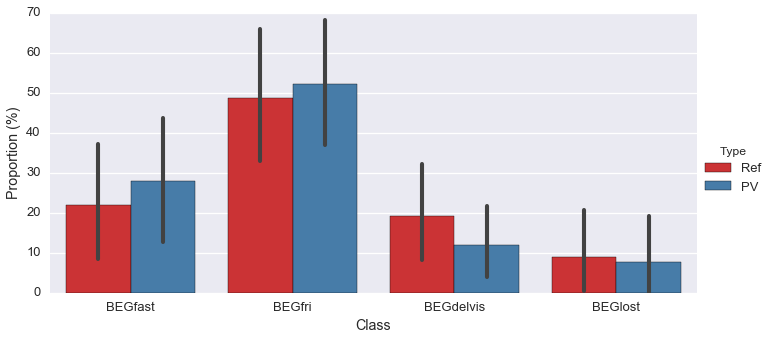

In [10]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='bar', 
              size=5, aspect=2, 
              estimator=np.mean, ci=95,
              palette='Set1')

It's clear there are no significant differences here. For an alternative view of the same data, we can also plot the bar heights as **medians**, rather than means.

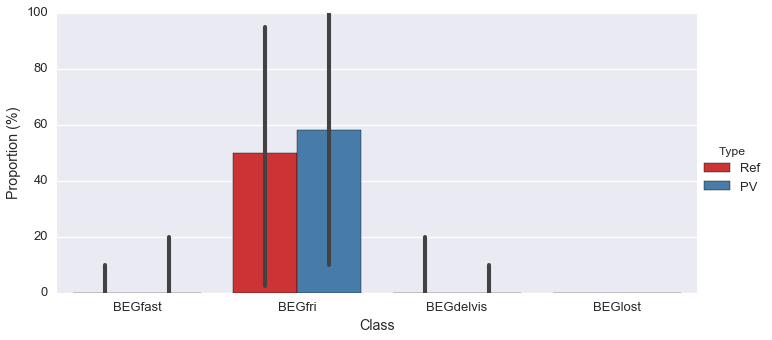

In [11]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='bar', 
              size=5, aspect=2, 
              estimator=np.median, ci=95,
              palette='Set1')

The differences here are even less obvious and the conclusions are the same - there are no significant differences in algal composition. Overall, the bar chart using means is probably a bit nicer to look at.

Finally, instead of bar charts we could create **box plots**. This would usually be my preferred option for this kind of data, but the dispersion is so large in this dataset that I suspect the bar plots will look nicer.

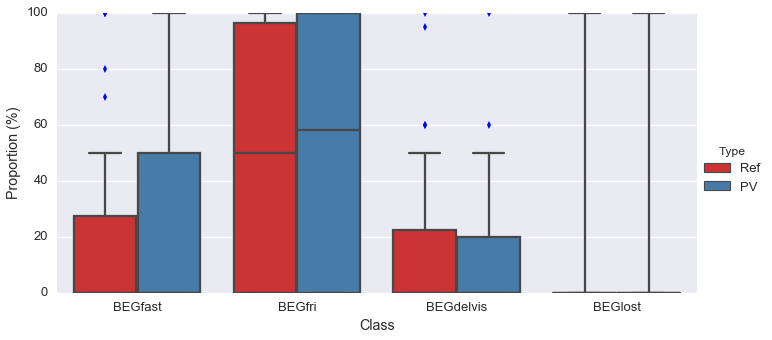

In [12]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, 
              kind='box', 
              size=5, aspect=2,
              palette='Set1')

Overall, I think I prefer the version where the bars represent the mean, although any of the above would be fine. We can also try a version split by river.

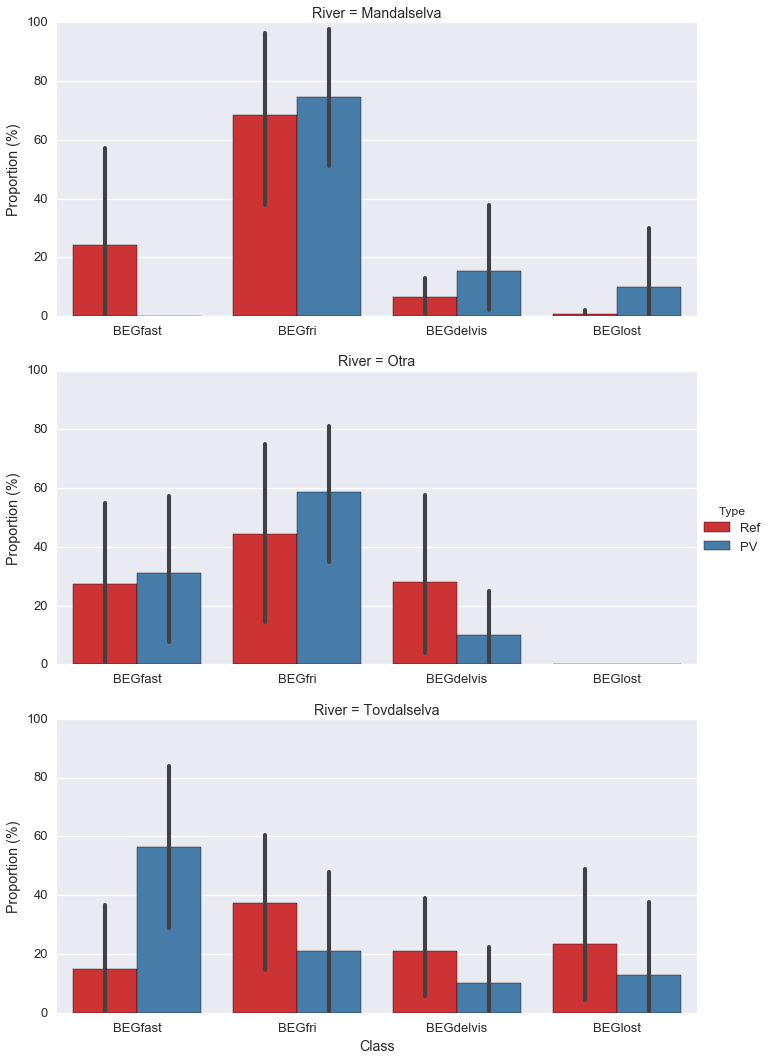

In [13]:
sn.factorplot(x='Class', y='Proportion (%)', hue='Type',
              data=alg_df, row='River',
              kind='bar', sharex=False,
              size=5, aspect=2, 
              estimator=np.mean, ci=95,
              palette='Set1')

## 2. Water chemistry

I've extracted the water chemistry data into a new Excel file called `chem.xlsx`. Note that some of the column headings in 2014 are slightly different to those in later years. I've tried to match them up as best I can, but **check with Therese to make sure I'm using the right data columns**. Also note that most of the chemistry data for 2016 seems to be missing, so **check this too**.

Where the measured values are either below or above the limits of detection, I've substituted the detection limit itself.

In [14]:
# Read data
in_xls = (r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data'
          r'\Tidied\chem.xlsx')
df = pd.read_excel(in_xls, sheetname='data')

# 'Melt' to long data format
df = pd.melt(df, 
             id_vars=['Kortnavn', 'Name', 'ID', 'Year'], 
             var_name='Param', 
             value_name='Value')

# Join in PV or Ref
df = pd.merge(df, typ_df,
              how='left', on='Name')

# Make sure I've corrected all the 'NA' and '<' values in the spreadsheet
# i.e. check 'value' is a float col, not an object col
print df.dtypes

df.head()

Kortnavn     object
Name         object
ID            int64
Year          int64
Param        object
Value       float64
Type         object
dtype: object


,Kortnavn,Name,ID,Year,Param,Value,Type
0,LOG,LOG,1,2014,Vann_cond,NaN,Ref
1,ÅSE,ASE,2,2014,Vann_cond,10.4,PV
2,SVE,SVE,3,2014,Vann_cond,10.8,PV
3,SME,SME,4,2014,Vann_cond,11.3,Ref
4,FYG,FYG,5,2014,Vann_cond,13.5,PV


### 2.1. Line plots per site

For each site, we can create a simple line plot for each chemical parameter in each year. There are 21 possible parameters, which I've arranged into a 4 by 6 grid below. The example shows the results for site `ASE`, but it would be easy to generate plots like this for all the other sites if desired.

**Check which parameters Therese actually wants plots for and adjust this as necessary**.

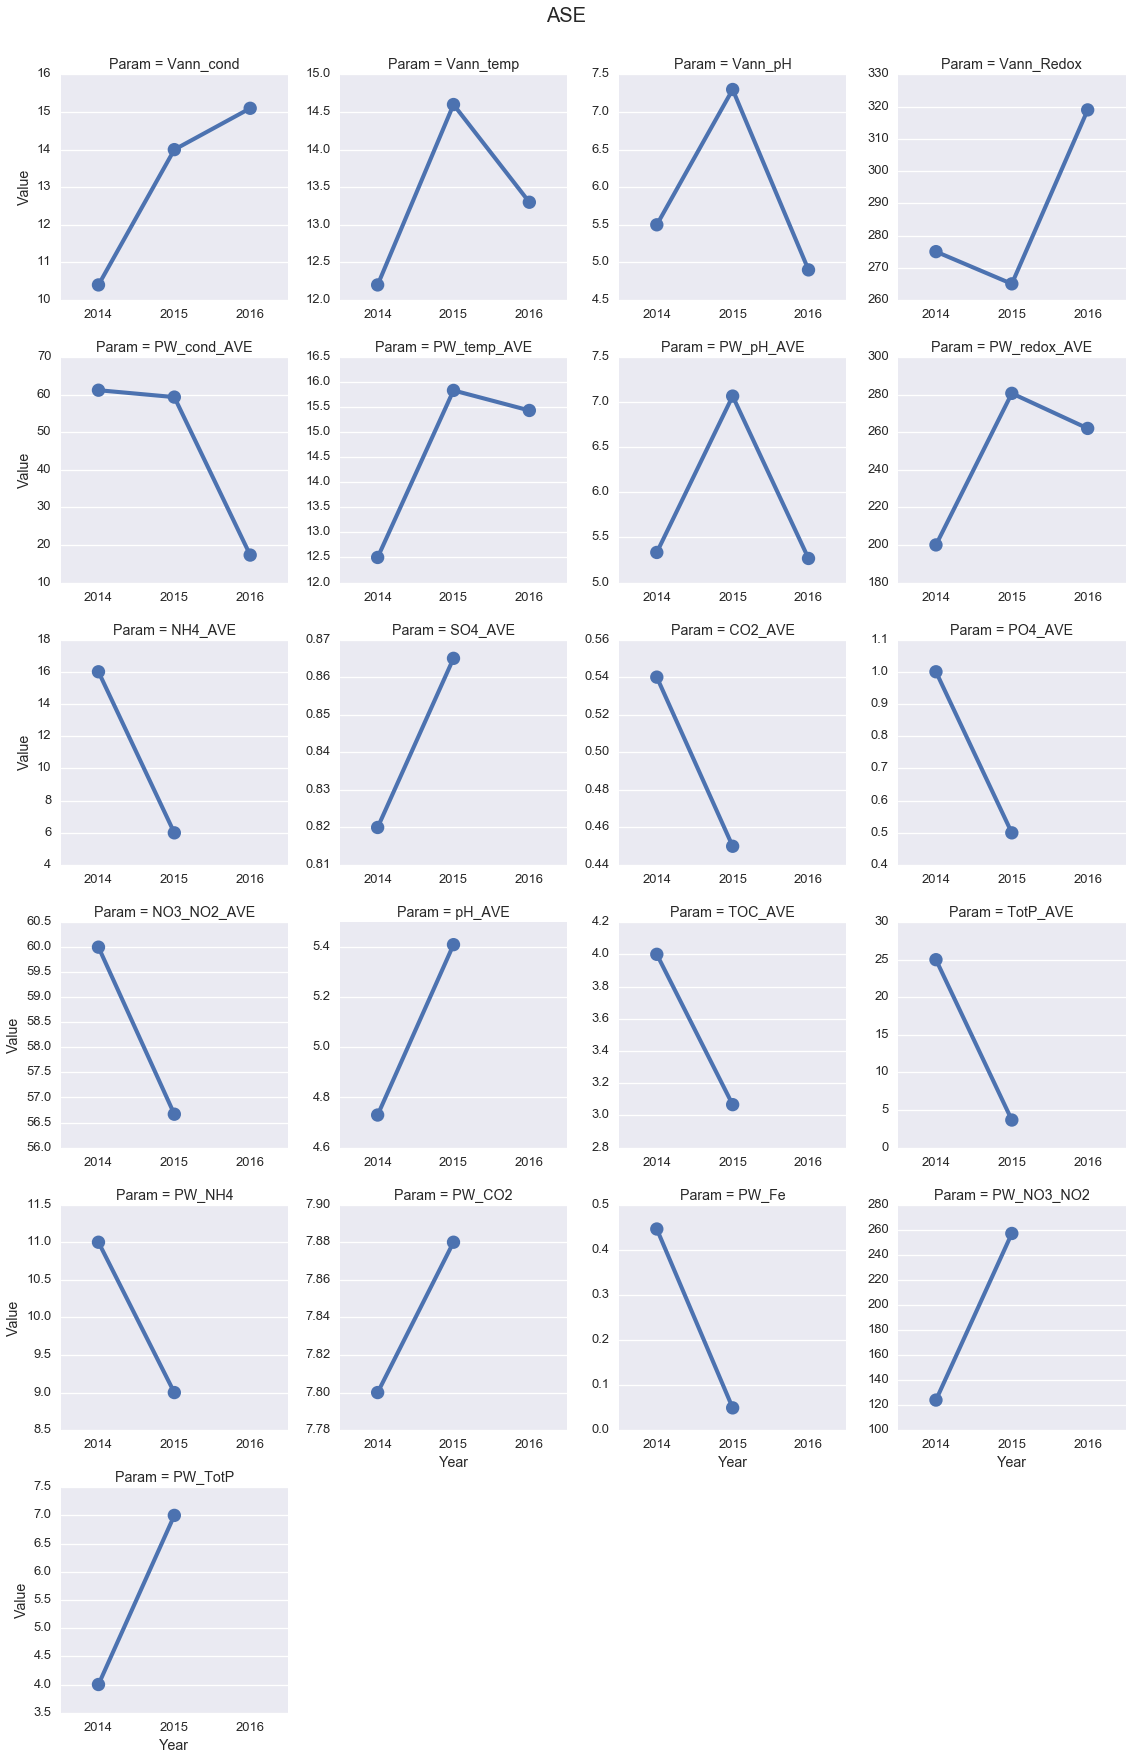

In [15]:
site_df = df.query('Name == "ASE"')

# Plot
sn.factorplot(x='Year', y='Value', 
              col='Param', col_wrap=4,
              data=site_df, 
              kind='point',
              sharex=False,
              sharey=False)

plt.suptitle('ASE', fontsize=20, y=1.02)

### 2.2. Line plots for nuisance versus non-nuisance

Therese's e-mail mentions line plots for all sites, aggregated according to whether they are nuisance or non-nuisance. On the plot below, each point represents the **mean** and the error bars are **95% confidence intervals** estimated by bootstrapping.

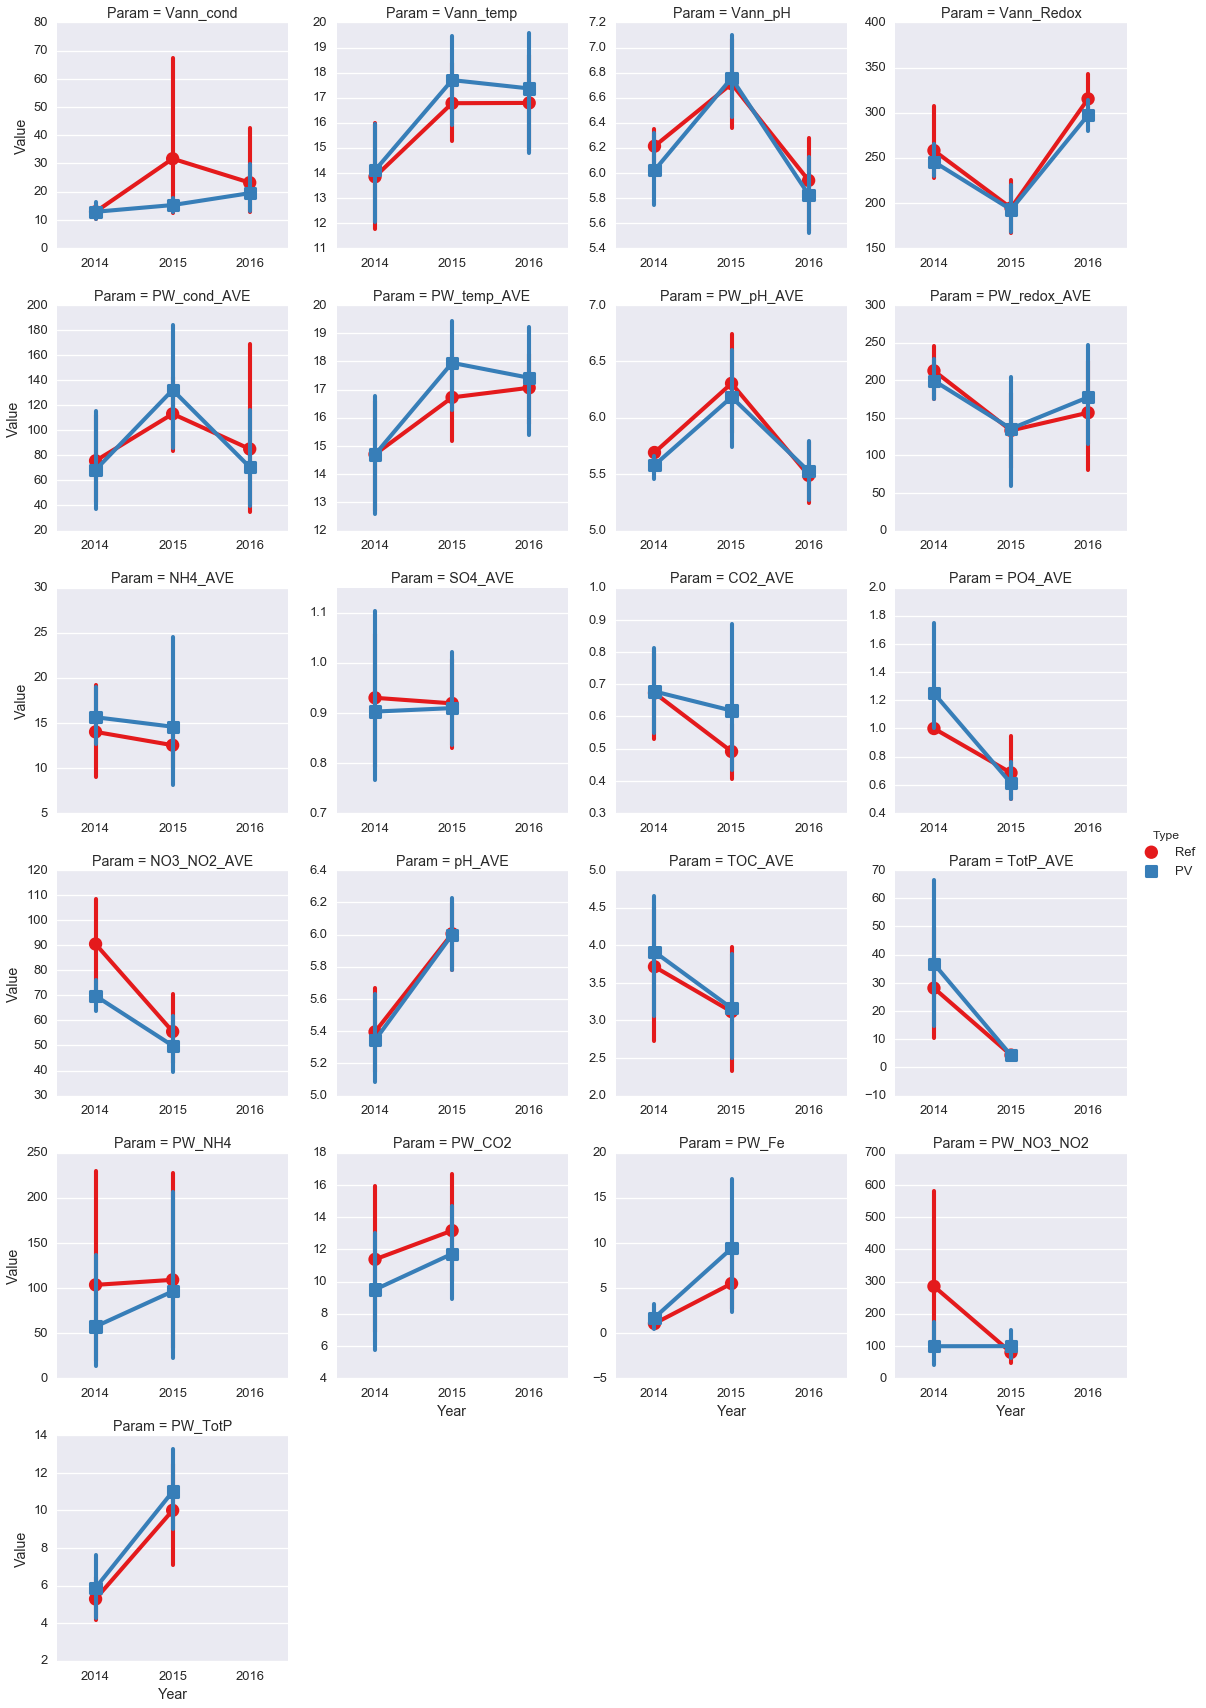

In [16]:
# Plot
sn.factorplot(x='Year', y='Value', hue='Type',
              col='Param', col_wrap=4,
              data=df, 
              kind='point',
              ci=95,
              sharex=False,
              sharey=False,
              margin_titles=True,
              markers=['o', 's'],
              palette='Set1')

### 2.3. Box plots for nuisance versus non-nuisance

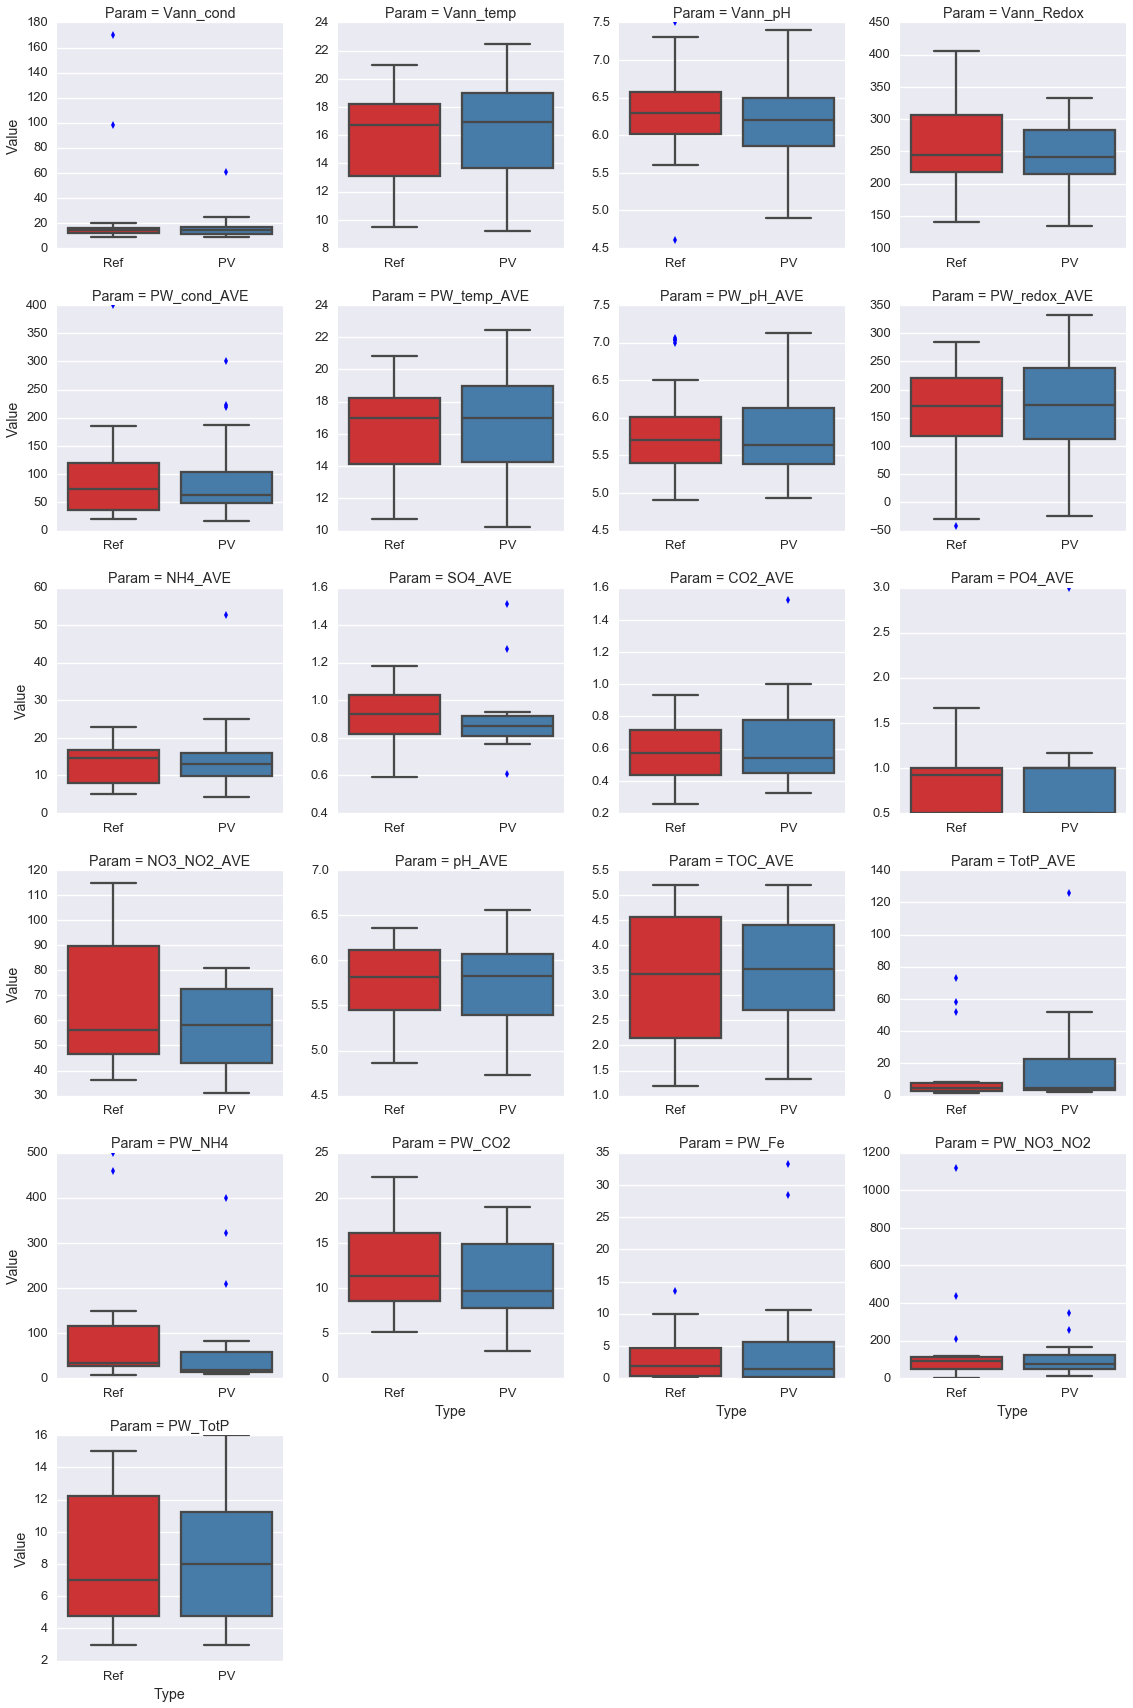

In [17]:
# Plot
sn.factorplot(x='Type', y='Value',
              col='Param', col_wrap=4,
              data=df, 
              kind='box',
              sharex=False,
              sharey=False,
              palette='Set1')

### 2.4. Box plots split by year and nuisance versus non-nuisance

The plot below is very similar to the line plot in section 2.2, except instead of showing means and 95% CIs, the plot below uses box plots to represent the variation.

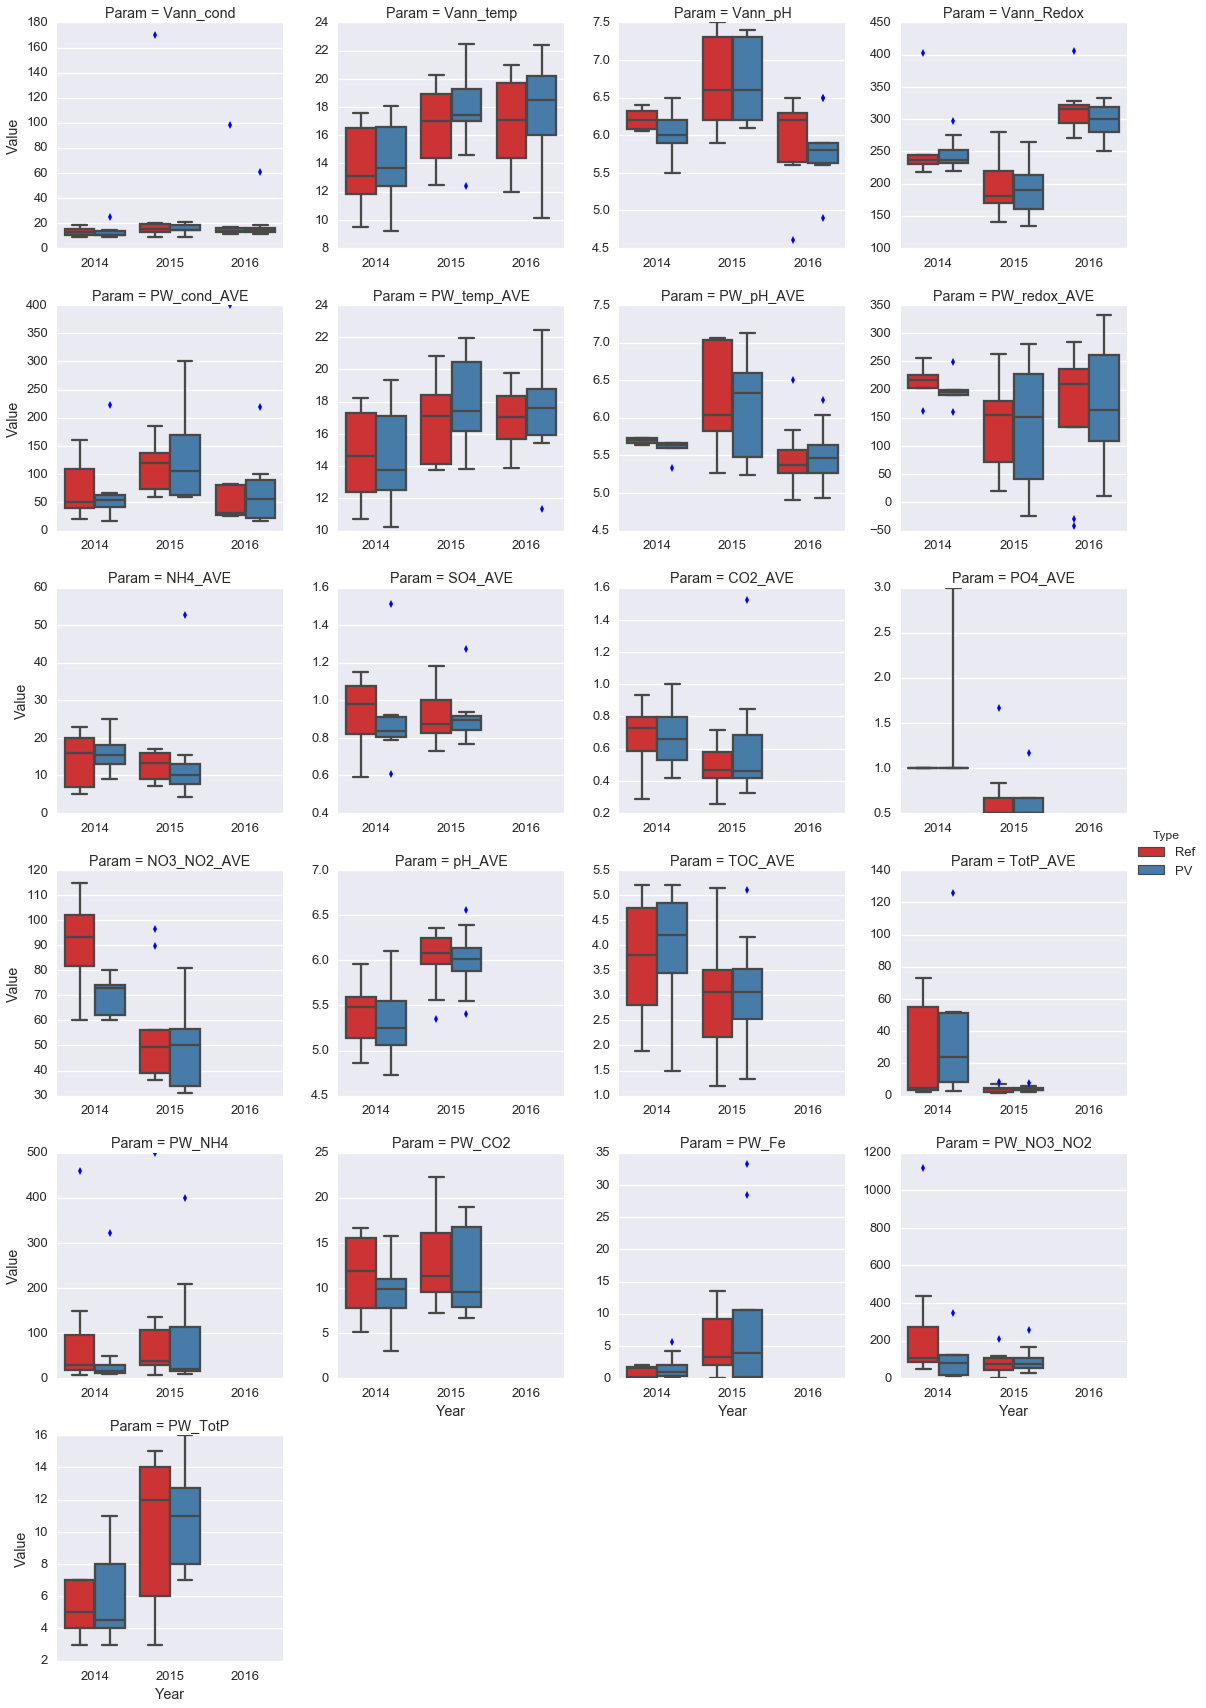

In [18]:
# Plot
sn.factorplot(x='Year', y='Value', hue='Type',
              col='Param', col_wrap=4,
              data=df, 
              kind='box',
              sharex=False,
              sharey=False,
              palette='Set1')

## 3. Water level and discharge

Most of the sites have pressure sensors recording the water level at a temporal resolution of 30 minutes. I believe discharge data has also been extracted (from HydraII?), but I can't find it in the project folders - **ask Kate and Therese about this**.

I'm also struggling to find some of the NVE sites in the HydraII database. I usually use [this map](http://www2.nve.no/h/hd/plotreal/Q/index.html) and [this list](http://www2.nve.no/h/hd/plotreal/Q/list.html) to get the site codes for searching the database, but many of the discharge stations on Therese's figure 7 are not shown on the map or list. **Do we have NVE codes for the stations in *Fig. 7* so I can try searching HydraII for more recent data?**

As a quick test, for the moment I'll focus on the following:

 1. Extract the HydraII flow data for Kjølemo, which is located between sites FYG and MID (and which *is* in the list linked above). It would be interesting to see how the stage data for these two krypsiv sites correlates with the flow data from Kjølemo. <br><br>
 
 2. Read the stage data for all the sites and check whether nuisance sites are associated with any obvious flow characteristics.
 
### 3.1. Prepare data

I've copied the stage data for FYG and MID and tidied the files up a bit (see `fyg_stage.xlsx` and `mid_stage.xlsx` for details). I've also downloaded the daily discharge dataset for Kjølemo (NVE ID 22.4.0) for the years 2014 and 2015 from HydraII (see `nve_kjolemo_22-4-0.xlsx`).

In [19]:
# Read data
fyg_xls = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data\Tidied\fyg_stage.xlsx'
mid_xls = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data\Tidied\mid_stage.xlsx'
kjo_xls = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data\Tidied\nve_kjolemo_22-4-0.xlsx'

fyg_df = pd.read_excel(fyg_xls, sheetname='fyg_stage',
                       index_col=0)

mid_df = pd.read_excel(mid_xls, sheetname='mid_stage',
                       index_col=0)

kjo_df = pd.read_excel(kjo_xls, sheetname='Sheet1',
                       index_col=0)

### 3.2. Krypsiv water level compared to NVE discharge

The NVE discharge data has daily resolution, so I'll start by down-sampling the stage data by calculating daily averages. We can then plot daily time series for each parameter during the period of overlap and see how they compare.

**Note:** The plots below are "interactive" - hovering the mouse over the plot area should display pan and zoom icons at the bottom-left of the plot, which can be used to explore the data.

In [20]:
# Downsample stage to daily
fyg_df_d = fyg_df.resample('D').mean()
mid_df_d = mid_df.resample('D').mean()
kjo_df_d = kjo_df.resample('D').mean()

# Join on dates
df = pd.concat([fyg_df_d, mid_df_d, kjo_df_d], axis=1)

# Drop no data
df.dropna(how='any', inplace=True)

# Get just the flow and stage columns
df = df[['kjo_q_m3ps', 'mid_level_m', 'fyg_level_m']]

# Plot
axes = df.plot(subplots=True, legend=False, 
               figsize=(10, 8))

# Tidy axes
for ax in axes:
    ax.legend(loc='best', title='')
    ax.set_xlabel('')
plt.tight_layout()

mpld3.display()

It's clear there is an agreement here between the NVE flow dataset and the stage records for the two krypsiv sites. Based on a quick visual inspection, it looks as though we can probably estimate flow at these two sites by area-scaling the NVE data (as long as we know the relative catchment areas). We can also derive approximate stage-discharge relations, which can be compared to those obtained from the manual flow-gauging that has been done at each site.

For now, I just want to look at the relationship between flow at Kjølemo and stage at the two krypsiv sites. The code in the cell below defines a convenience function for simple linear regression.

In [21]:
# Linear regression
def lin_reg(df, formula, resp, explan, hue=None):
    """ Function to perform simple (OLS) linear regression.
    
    Args:
        df       Dataframe whose columns include resp and explan
        formula  Regression equation, specified using patsy
        resp     Name of response variable
        explan   Name of explanatory variable
        hue      Split point according to category if desired
    
    Returns:
        None. The function produces the following plots.
            - Summary of the regression output (significant, AIC etc.)
            - Histograms of resp and explan, to help the user decide whether 
              transformation(s) are necessary.
            - Plot of the fitted model, including 95% confidence intervals
              around the fitted lines
            - Plot of residuals to aid model evaluation            
    """
    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    # Histograms
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sn.distplot(df[explan], kde=True, ax=axes[0])
    sn.distplot(df[resp], kde=True, ax=axes[1])
    axes[0].set_title(explan)
    axes[1].set_title(resp)
    
    # Perform regression
    reg = ols(formula=formula, data=df).fit()
    print reg.summary()

    # Plot
    if hue:
        sn.lmplot(x=explan, y=resp, hue=hue,
                  data=df, size=8, markers=['o', 'x'], 
                  ci=95, palette='Set1')
    else:
        sn.lmplot(x=explan, y=resp,
                  data=df, size=8,
                  ci=95, palette='Set1')
        
    # Plot residuals
    sn.jointplot(x=df[explan], y=reg.resid, 
                 kind='reg', stat_func=None)
    plt.ylabel('Residuals')

The next step is to convert the daily data to "long" format and perform the regression.

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2800.
Date:                Mon, 31 Oct 2016   Prob (F-statistic):          2.83e-232
Time:                        11:20:35   Log-Likelihood:                 165.41
No. Observations:                 330   AIC:                            -322.8
Df Residuals:                     326   BIC:                            -307.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------

C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
C:\Data\64_Bit_WinPython\python-2.7.10.amd64\lib\site-packages\numpy\lib\function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


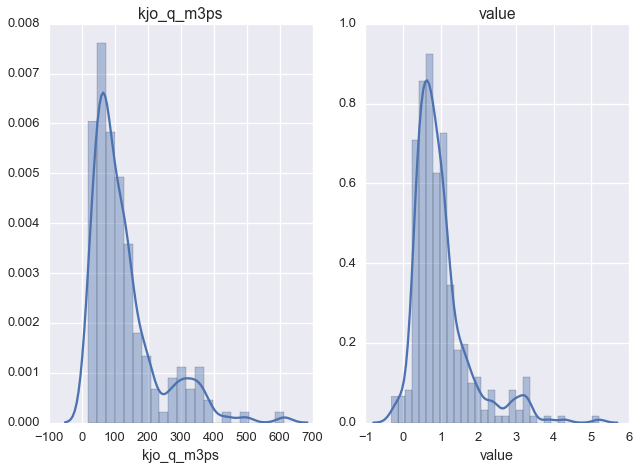

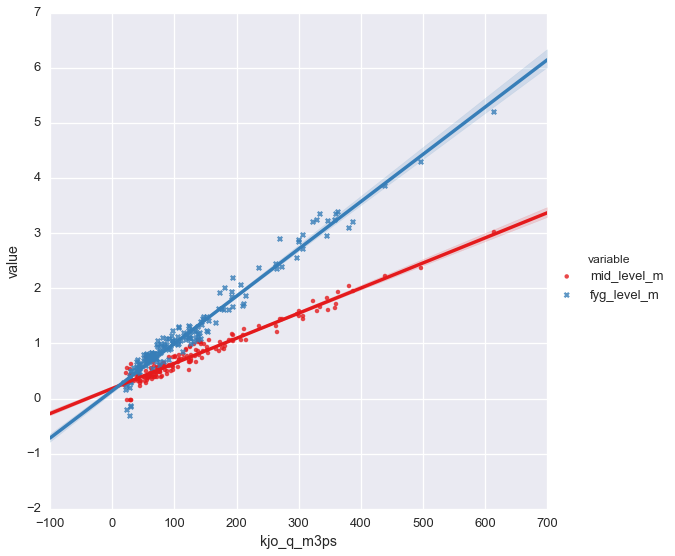

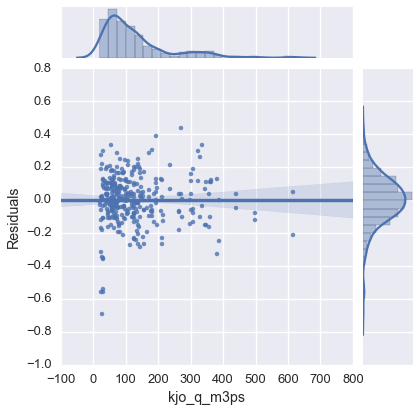

In [22]:
# Convert to long
reg_df = pd.melt(df, id_vars='kjo_q_m3ps')

# Perform lin reg, allowing different slopes and intercepts
# for each site
lin_reg(reg_df,
        'value ~ kjo_q_m3ps * C(variable)',
        'value', 'kjo_q_m3ps', hue='variable')

These regressions work well, but it's surprising to see such a linear relationship between stage and flow (usually these relationships follow some kind of polynomial or power-law). **The simplest interpretation is that the channel cross-sections at FYG and MID must be approximately rectangular with laminar flow - is this reasonable?** 

The regression model fits the data well and the residuals are approximately normally distributed. These results essentailly show that, to a rough approximation, $Q_{kjo} = 0.0086*S_{fyg}$ and $Q_{kjo} = 0.0046*S_{fyg}$. These relationships aren't especially useful in themselves, but they do suggest that, if we had catchment areas for FYG and MID, we could estimate discharge fairly reliably from the NVE record at Kjølemo.

### 3.3. Flow characteristics between nuisance and non-nuisance sites

The raw stage data for all sites is on the network here:

K:\Avdeling\318 Ferskvannsøkologi\Prosjekter\2016 JBovervåk16-18 (TFM)\04 Vannføring\HOBO\Calibrated_hobologgers

I've copied these files locally, removed the Norwegian special characters from the file names, and tidied up some of the columns and file extensions to make them all consistent. The code below reads each file, extracts the stage information and creates box plots showing the variability in stages at nuisance versus non-nuisance sites.


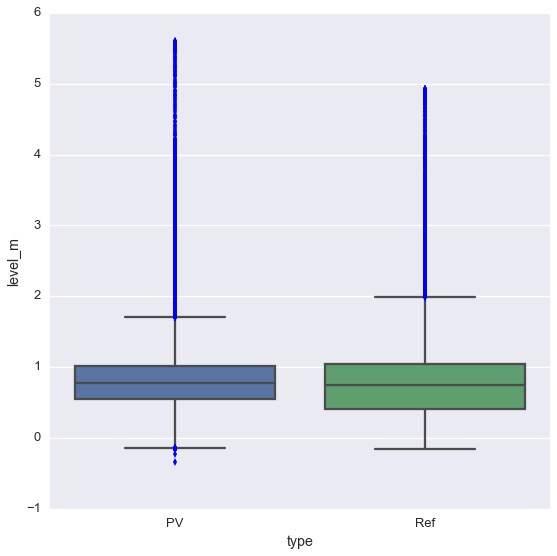

In [23]:
# Folder of raw stage data
stage_fold = r'C:\Data\James_Work\Staff\Therese_FM\Bulbous_Rushes\Data\Tidied\stage'

# Get list of files to process
search_path = os.path.join(stage_fold, '*')
file_list = glob.glob(search_path)

df_list = []

# Loop over data
for xls in file_list:
    # Get props from file name
    name = os.path.split(xls)[1]
    site = name.split('_')[1]

    # Get whether ref or PV
    typ = typ_df.query('Name == @site').iloc[0]['Type']
    
    # Read data. Only need levels
    stg_df = pd.read_excel(xls, sheetname=0, skiprows=1,
                           parse_cols='G')
    stg_df.columns = ['level_m']
    
    # Add type
    stg_df['type'] = typ
    
    df_list.append(stg_df)

df = pd.concat(df_list, axis=0)

# Plot
sn.factorplot(x='type', y='level_m',
              data=df, 
              kind='box',
              size=8)

Based on this, there are no obvious differences in the distribution of water levels between nuisance and non-nuisance sites. 

If we managed to estimate flow records for these sites (either by scaling from NVE or using the flow gauging data), we might be able to look at the hydrological regime in more detail. For example, if we know the discharge and average slope of the streams in the vicinity of the krypsiv beds, we can estimate [stream power](https://en.wikipedia.org/wiki/Stream_power), which could give an indication of the physical stress exerted on the substarte (and krypsiv) at each site. 